In [223]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import torch

In [224]:
data = pd.read_csv("input/GS_South_Pars.csv")

In [225]:
# Separate features (first 11 columns) and target
X = data.iloc[:, :11].values  # First 11 columns as features
y = data['MH2O(MOL/HR)'].values.reshape(-1, 1)  # Target variable, reshaped to 2D

In [226]:
# Split data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.30, random_state=42)

In [227]:
# Confirming the split ratios
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (11888, 11), Validation set: (5096, 11), Test set: (4246, 11)


In [228]:
# Scale features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

In [229]:
# Scale target using MinMaxScaler (or StandardScaler for more normalized distribution)
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val = scaler_y.transform(y_val.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

In [230]:
# Initialize an enhanced TabNet model configuration
model5 = TabNetRegressor(
    n_d=128,  # Larger embedding dimension
    n_a=128,  # Larger attention dimension
    n_steps=10,  # Increased decision steps for complexity
    gamma=1.5,  # Feature reusage penalty
    n_independent=3,  # More independent FC layers
    n_shared=3,  # More shared FC layers
    lambda_sparse=1e-4,  # Reduce regularization for less sparsity
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5e-4, weight_decay=1e-5),  # Lower learning rate
    mask_type='entmax',  # Sparsemax for feature selection
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,  # New scheduler for stability
    scheduler_params={"mode": "min", "factor": 0.7, "patience": 10, "verbose": True}
)


c:\Users\mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [231]:
# Train the model with new configurations
model5.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_name=['val'],
    eval_metric=['rmse'],
    max_epochs=500,  # More epochs for thorough training
    patience=50,  # Higher patience for better convergence
    batch_size=15,  # Larger batch size
    virtual_batch_size=32,
    num_workers=0,
    drop_last=False
)

c:\Users\mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


epoch 0  | loss: 7.75318 | val_rmse: 1.75164 |  0:01:30s
epoch 1  | loss: 2.56166 | val_rmse: 0.94687 |  0:02:59s
epoch 2  | loss: 1.44597 | val_rmse: 0.856   |  0:04:33s
epoch 3  | loss: 0.78081 | val_rmse: 0.96335 |  0:06:09s
epoch 4  | loss: 0.45467 | val_rmse: 0.52072 |  0:07:52s
epoch 5  | loss: 0.258   | val_rmse: 0.47322 |  0:09:36s
epoch 6  | loss: 0.17184 | val_rmse: 0.32052 |  0:11:13s
epoch 7  | loss: 0.10439 | val_rmse: 0.19934 |  0:12:51s
epoch 8  | loss: 0.05816 | val_rmse: 0.20716 |  0:14:29s
epoch 9  | loss: 0.03866 | val_rmse: 0.16275 |  0:16:07s
epoch 10 | loss: 0.02729 | val_rmse: 0.14245 |  0:17:46s
epoch 11 | loss: 0.02232 | val_rmse: 0.14222 |  0:19:26s
epoch 12 | loss: 0.01829 | val_rmse: 0.10017 |  0:21:12s
epoch 13 | loss: 0.0166  | val_rmse: 0.08979 |  0:22:56s
epoch 14 | loss: 0.0142  | val_rmse: 0.0874  |  0:24:44s
epoch 15 | loss: 0.0135  | val_rmse: 0.08617 |  0:26:31s
epoch 16 | loss: 0.01274 | val_rmse: 0.08235 |  0:28:14s
epoch 17 | loss: 0.01211 | val_

c:\Users\mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [232]:
# Predict and rescale on the test set
y_pred_scaled = model5.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Inverse transform to original scale
y_test_original = scaler_y.inverse_transform(y_test)  # Original scale for comparison

In [233]:
# Evaluate performance with MSE and R²
import numpy as np

mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error on Test Set: {mse}')
print(f'R² Score on Test Set: {r2}')
print(f'RMSE for MH2O(MOL/HR): {rmse}')

Mean Squared Error on Test Set: 74867424.32696338
R² Score on Test Set: 0.9921356835877727
RMSE for MH2O(MOL/HR): 8652.596392237614


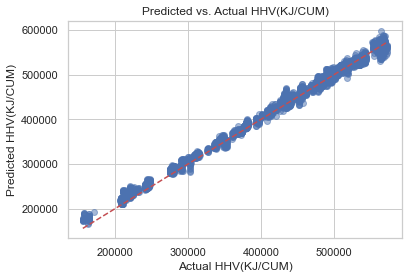

In [234]:
import matplotlib.pyplot as plt

plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.xlabel("Actual HHV(KJ/CUM)")
plt.ylabel("Predicted HHV(KJ/CUM)")
plt.title("Predicted vs. Actual HHV(KJ/CUM)")
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.show()

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [236]:
# Set plot style for a professional look
sns.set(style="whitegrid", palette="muted")

C:\Users\mostafa\AppData\Local\Temp\ipykernel_2248\2425881574.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sc)


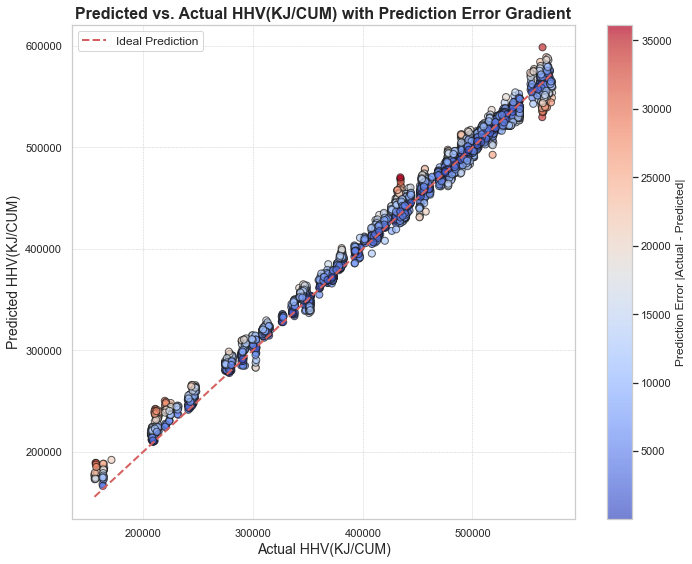

In [237]:
# Set plot style for a professional look
sns.set(style="whitegrid", palette="muted")

# Set figure size and create a scatter plot with color gradient
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    y_test_original, y_pred, 
    c=np.abs(y_pred - y_test_original), 
    cmap="coolwarm", s=50, alpha=0.7, edgecolor="k"
)

# Add color bar to indicate prediction error (absolute difference)
cbar = plt.colorbar(sc)
cbar.set_label("Prediction Error |Actual - Predicted|", fontsize=12)

# Plot a 1:1 line for reference
plt.plot(
    [y_test_original.min(), y_test_original.max()], 
    [y_test_original.min(), y_test_original.max()], 
    'r--', lw=2, label="Ideal Prediction"
)

# Set axis labels and title with enhanced font size
plt.xlabel("Actual HHV(KJ/CUM)", fontsize=14)
plt.ylabel("Predicted HHV(KJ/CUM)", fontsize=14)
plt.title("Predicted vs. Actual HHV(KJ/CUM) with Prediction Error Gradient", fontsize=16, fontweight='bold')

# Customize legend and plot aesthetics
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

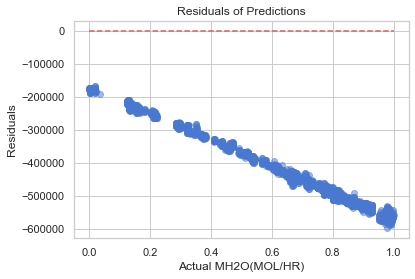

In [238]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals, alpha=0.5)
plt.hlines(0, y_test.min(), y_test.max(), colors='r', linestyles='dashed')
plt.xlabel("Actual MH2O(MOL/HR)")
plt.ylabel("Residuals")
plt.title("Residuals of Predictions")
plt.show()

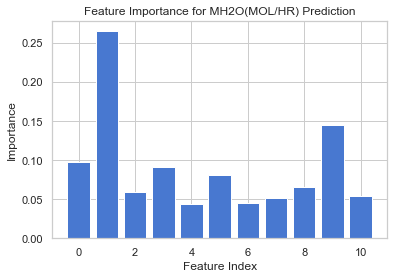

In [239]:
feature_importances = model5.feature_importances_
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance for MH2O(MOL/HR) Prediction")
plt.show()

In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [241]:
# Example feature names (replace with actual feature names if available)
feature_names = ["CO2(in)", "H2S(in)","N2(in)","C1(in)","C2(in)","C3(in)","IC4(in)","HEX-T-HOT-C","REG-COL-MOLE-RR","GASIN-MASSFLOW-(KG/HR)","VALVE-P-OUT-(BAR)"]

In [242]:
# Feature importances from the model
feature_importances = model5.feature_importances_

In [243]:
# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

In [244]:
# Sort by importance for a more informative visualization
importance_df = importance_df.sort_values(by="Importance", ascending=True)

In [245]:
# Set up a larger, more readable figure size
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")


<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

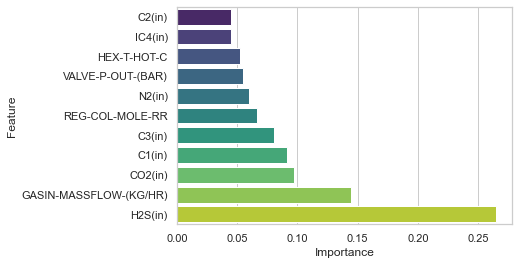

In [246]:
# Horizontal bar plot
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")

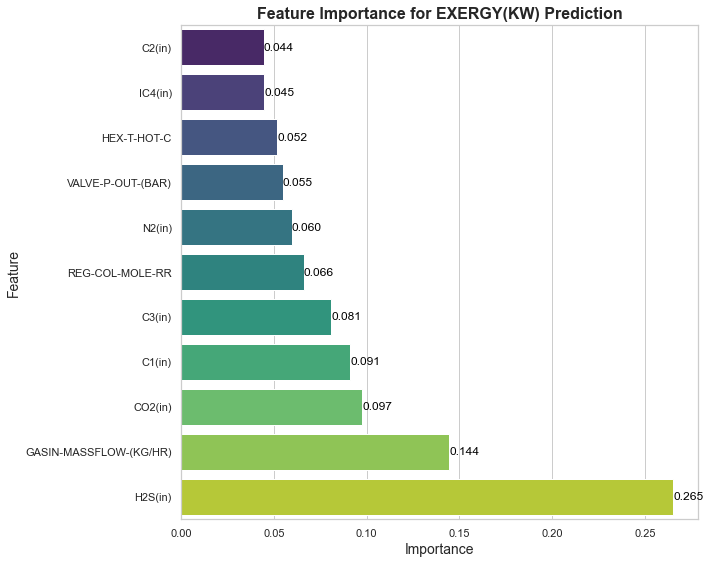

In [247]:
# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance for a more informative visualization
importance_df = importance_df.sort_values(by="Importance", ascending=True)

# Set up a larger, more readable figure size
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Horizontal bar plot
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")

# Add title and labels
plt.title("Feature Importance for EXERGY(KW) Prediction", fontsize=16, fontweight='bold')
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Add data labels to each bar for clarity
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', color='black', ha="left", va="center")

plt.tight_layout()
plt.show()